In [1]:
%load_ext zipline
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [68]:
from zipline.utils import factory
from zipline.api import symbol, order, record
import numpy as np
from datetime import datetime, date
import pytz
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import os
import collections
from StringIO import StringIO

dictData = collections.OrderedDict()

parse = lambda x: datetime.strptime(x, '%d-%m-%y').date()

dict={}
array = np.array(['BTCUSD','LTCUSD','DOGEBTC','XRPUSD','DASHBTC','MAIDBTC','XMRBTC','BTSBTC','BTCETH','FCTBTC'])


for x in array:
    dict["{0}".format(x)] = pd.read_csv('/Users/JH/Desktop/Business/GGSB Thesis 2016/Code/excelled data/'+x+'.csv', index_col=['Timestamp'], 
                                  usecols=['Timestamp','Open','High','Low','Close','Volume','VWAP'], sep=';',
                                  parse_dates=True, date_parser=parse)

dictData = dict

In [69]:
panel = pd.Panel(dictData)
panel.minor_axis = ['open', 'high', 'low', 'close', 'volume','vwap']
# panel.drop('vwap','minor_axis') doesn't work? 
print(panel)
# print(panel.minor_axis)
# print(panel['DOGEBTC'])

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 803 (major_axis) x 6 (minor_axis)
Items axis: BTCETH to XRPUSD
Major_axis axis: 2014-04-01 00:00:00 to 2016-06-11 00:00:00
Minor_axis axis: open to vwap


In [70]:
sim_params = factory.create_simulation_parameters(
    start=pd.to_datetime("01-04-14", dayfirst=True).tz_localize("Europe/London").tz_convert("UTC"),
    end=pd.to_datetime("11-06-16", dayfirst=True).tz_localize("Europe/London").tz_convert("UTC"),
    data_frequency="daily",
    emission_rate="daily")

#data = data.dropna()

In [71]:
# SYMBOL METADATA

from zipline.algorithm import TradingAlgorithm
from zipline.api import order, order_target_percent, symbol, get_datetime
from zipline.protocol import BarData
# from zipline.utils import tradingcalendar as tcal


import matplotlib.pyplot as plt

# def initialize(algo):
#     algo.days = [date(2014,4,1),date(2014,5,1),date(2014,7,1),date(2014,10,1),date(2015,9,1),date(2016,2,1)]
# 
#     
# def handle_data(algo, data):
#     
# 
# algo_obj = TradingAlgorithm(initialize=initialize, handle_data=handle_data, sim_params=sim_params)
# perf_manual = algo_obj.run(data=panel, overwrite_sim_params=False)

[None, None, None, None, None, None, None, None, None, None]

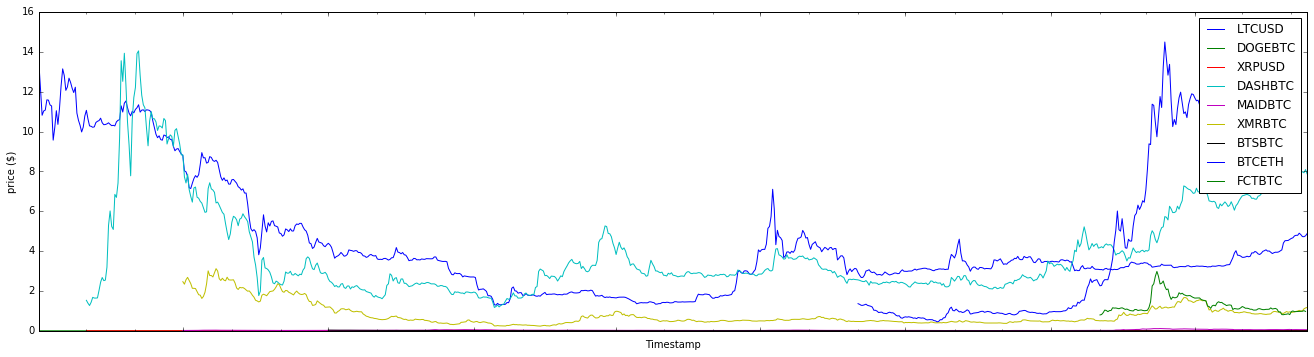

In [111]:
ax1 = plt.subplot(621)
# del dictData['BTCUSD']['Volume']
# dictData['BTCUSD']['Volume']
# SEE https://stats.stackexchange.com/questions/19426/scaling-data-that-are-on-different-scales-for-a-graph
# ax2 = ax1.twinx()
for x in array:
    if x == 'BTCUSD':
        # dictData[x]['VWAP'].plot(ax=ax2,label=str(x))
        pass
    else:
        dictData[x]['VWAP'].plot(ax=ax1,label=str(x))
plt.ylabel('price ($)')
# ax1.lines.pop(4)
plt.gcf().set_size_inches(50,40)
plt.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

In [63]:
# ACTUAL ETF BACKTESTING

#      order(symbol('BTCUSD'), 1000)
#      order(symbol('LTCUSD'), 10)
#      order(symbol('DOGEBTC'), 100)
# if event_day == algo.days[1]: 
#     # 20%
#     order(symbol('XRPUSD'), 1000)
#     order(symbol('DASHBTC'), 10000)
# if event_day == algo.days[2]:
#     # 14%
#     order(symbol('MAIDBTC'), 10000)
#     order(symbol('XMRBTC'), 10000)
# if event_day == algo.days[3]:
#     # 12.5%
#     order(symbol('BTSBTC'), 10000)
# if event_day == algo.days[4]:
#     # 11.1%
#     order(symbol('BTCETH'), 10000)
# if event_day == algo.days[5]:
#     # 10%
#     order(symbol('FCTBTC'), 10000)

# This is only used if wanting to leave out elements in symbol array
edit = True
if edit:
    a = np.ma.array(array, mask=False)
    a.mask[4] = True
else:
    a = array

def initialize(algo):
    algo.days = [date(2014,4,1),date(2014,5,1),date(2014,7,1),date(2014,10,1),date(2015,9,1),date(2016,2,1)]

# ETF trading 'strategy'
def handle_data(algo, data):
    
    event_day = get_datetime(None).date()
        
    # WEIGHTING: equal weighting (needs consistent rebalancing - right now only rebalances when new symbol data becomes available)    
    if event_day == algo.days[0]: 
        # 33% each
        for s in a[:3]:
            if s is np.ma.masked :
                pass
            else:
                order_target_percent(symbol(s), 0.33)
    if event_day == algo.days[1]: 
        # 20%
        for s in a[:5]:
            if s is np.ma.masked :
                pass
            else:
                order_target_percent(symbol(s), 0.2)
    if event_day == algo.days[2]:
        # 14%
        for s in a[:7]:
            if s is np.ma.masked :
                pass
            else:
                order_target_percent(symbol(s), 0.14)
    if event_day == algo.days[3]:
        # 12.5%
        for s in a[:8]:
            if s is np.ma.masked :
                pass
            else:
                order_target_percent(symbol(s), 0.125)
    if event_day == algo.days[4]:
        # 11.1%
        for s in a[:9]:
            if s is np.ma.masked :
                pass
            else:
                order_target_percent(symbol(s), 0.111)
    if event_day == algo.days[5]:
        # 10%
        for s in a:
            if s is np.ma.masked :
                pass
            else:
                order_target_percent(symbol(s), 0.1)

    # WEIGHTING: market cap weightings
        #      order(symbol('BTCUSD'), 1000)
        #      order(symbol('LTCUSD'), 10)
        #      order(symbol('DOGEBTC'), 100)
        # if event_day == algo.days[1]: 
        #     # 20%
        #     order(symbol('XRPUSD'), 1000)
        #     order(symbol('DASHBTC'), 10000)
        # if event_day == algo.days[2]:
        #     # 14%
        #     order(symbol('MAIDBTC'), 10000)
        #     order(symbol('XMRBTC'), 10000)
        # if event_day == algo.days[3]:
        #     # 12.5%
        #     order(symbol('BTSBTC'), 10000)
        # if event_day == algo.days[4]:
        #     # 11.1%
        #     order(symbol('BTCETH'), 10000)
        # if event_day == algo.days[5]:
        #     # 10%
        #     order(symbol('FCTBTC'), 10000) 
    



algo_obj = TradingAlgorithm(initialize=initialize, handle_data=handle_data, sim_params=sim_params)
perf_manual = algo_obj.run(data=panel, overwrite_sim_params=False)


#def analyze(algo, perf_manual):







 
 
# ax2 = plt.subplot(212, sharex=ax1)
# perf_manual.DOGEBTC.plot(ax=ax2)
# 
# 
# plt.gcf().set_size_inches(18, 8)
# plt.show()

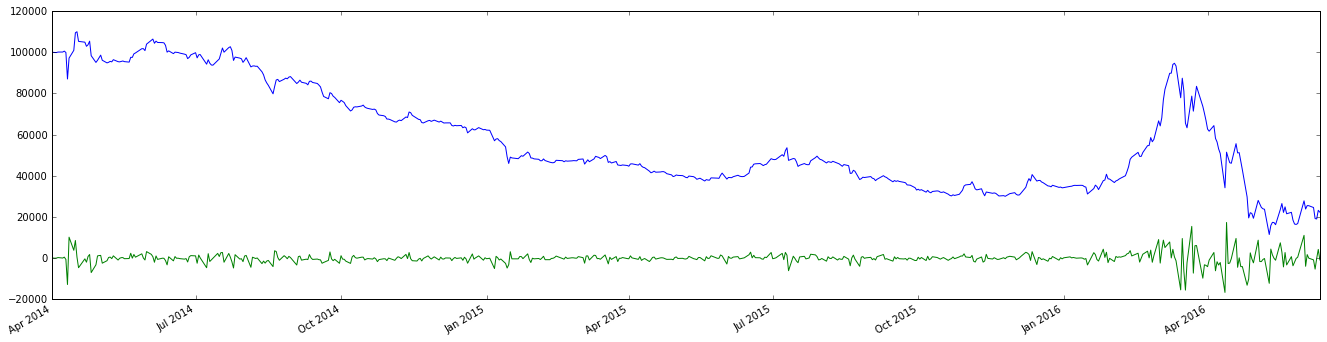

In [64]:
# This works fine
# ax1 = plt.subplot(621)
# del dogebtc['Volume']
# dogebtc.plot(ax=ax1)
# plt.ylabel('price')
# # ax1.lines.pop(4)
# plt.setp(ax1.get_xticklabels(), visible=True)

# Portfolio value
ax1 = plt.subplot(621)
perf_manual.portfolio_value.plot(ax=ax1)
ax2 = plt.subplot(621)
perf_manual.pnl.plot(ax=ax1)

plt.gcf().set_size_inches(50,40)
#plt.savefig('15.png',bbox_inches='tight')
plt.show()